In [17]:
import os
import sys
from concurrent.futures import ThreadPoolExecutor
from typing import Any, Dict, List, Optional, Set, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [18]:

SEED = 42
SHOW_PLOTS = True
USE_PARALLEL = True

ROOT_DIR = os.path.abspath(os.path.join(os.getcwd(), "..")) if os.path.basename(os.getcwd()) == "notebooks_new" else os.path.abspath(os.getcwd())
if ROOT_DIR not in sys.path:
    sys.path.append(ROOT_DIR)

OUT_DIR = os.path.join(ROOT_DIR, "results", "comm")

# Data source under data/model/
SOURCE_SUBDIR = "programs_for_you"

# Tower split: first 4 towers for training (8 trials), last 2 towers for test (4 trials)
TOWER_ORDER = ["CL", "CPi", "PiC", "LPi", "LC", "PiL"]
TRAIN_TOWERS = set(TOWER_ORDER[:4])
TEST_TOWERS = set(TOWER_ORDER[-2:])
TRAIN_NUM_TRIALS_PER_PPT = 8
TEST_NUM_TRIALS_PER_PPT = 4

# Training protocol
NUM_GENERATIONS = 50

# Test protocol
TEST_NUM_PPTS = 5

# Lexicon prior / utterance inventory
LEXEMES = ["blah", "blab", "bloop", "bleep", "floop"]

# RSA parameters
SPEAKER_ALPHA_PROG = 2.5    # temperature for program choice
SPEAKER_ALPHA_UTT = 2.5    # temperature for utterance choice
SPEAKER_BETA_COST = 0.3    # cost vs informativity trade-off
EPSILON = 0.01             # epsilon for softmax, to prevent degeneration

# Pact-Aware parameters (Brennan & Clark style)
PACT_GAMMA = 0.5           # weight of switching cost in utility
PACT_ETA = 1.0             # scaling factor for pact strength
REPAIR_MAX_TURNS = 2       # max clarification turns per step

# Drift-Biased parameters (Bentley neutral copying)
DRIFT_EPSILON = 0.3        # probability of copying channel
DRIFT_TAU = 1.0            # exponent for frequency-based copying (1.0 = pure random copying)
DRIFT_MU = 0.05            # innovation probability within copying channel
DRIFT_POOL_WEIGHT_PREV_GEN = 0.6  # weight of previous-gen pool vs within-ppt pool

# Models to run
MODEL_SPECS = [
    {"model": "learning_agent"},
    {"model": "strategic_agent"},
    {"model": "strategic_agent_pact"},
    {"model": "strategic_agent_drift"},
]

np.random.seed(int(SEED))

In [9]:
# Cultural transmission bottleneck parameters
TRANSMIT_MAX_PAIRS = 1000
TRANSMIT_SAMPLE_RATE = 1.0
TRANSMIT_INCLUDE_REPAIRS = False

# Adaptive weight parameters
PRIOR_W_MIN = 0.1
PRIOR_W_MAX = 1.0
PRIOR_W_SCALE = 0.5
LL_W_MIN = 0.5
LL_W_MAX = 3.0
LL_W_SCALE = 2.0

In [10]:
# Imports from model module
from model.convention_formation.distribution import LexiconPrior
from model.speaker_policies import (
    softmax_np, entropy_np, as_float, extract_chunks,
    B0, A0, update_beliefs, expected_inf,
    choose_utterance_rsa, compute_program_base_utility,
    choose_program_rsa, compute_lexeme_mapping_entropy,
    PactMemory, choose_program_pact,
    DriftPool, choose_program_drift,
)
from model.convention_formation.lexicon import BlockLexicon
from model.speaker_policies import update_beliefs as update_beliefs_modular

In [11]:
# Imports that depend on ROOT_DIR being importable
from model.convention_formation.distribution import LexiconPrior, EmptyDistribution
from model.convention_formation.lexicon import BlockLexicon

In [12]:
def list_available_ppt_ids(data_dir: str) -> List[int]:
    out: List[int] = []
    for fn in os.listdir(data_dir):
        if not (fn.startswith("programs_ppt_") and fn.endswith(".json")):
            continue
        core = fn[len("programs_ppt_") : -len(".json")]
        try:
            out.append(int(core))
        except ValueError:
            continue
    return sorted(out)


def trials_path(ppt_id: int) -> str:
    return os.path.join(ROOT_DIR, "data", "model", SOURCE_SUBDIR, f"programs_ppt_{int(ppt_id)}.json")


def load_trials(ppt_id: int) -> pd.DataFrame:
    return pd.read_json(trials_path(int(ppt_id)))


def split_train_test_trials(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    train_df = df[df["towers"].isin(list(TRAIN_TOWERS))].copy()
    test_df = df[df["towers"].isin(list(TEST_TOWERS))].copy()
    if len(train_df) != int(TRAIN_NUM_TRIALS_PER_PPT):
        raise ValueError(f"Expected {TRAIN_NUM_TRIALS_PER_PPT} train trials, got {len(train_df)}.")
    if len(test_df) != int(TEST_NUM_TRIALS_PER_PPT):
        raise ValueError(f"Expected {TEST_NUM_TRIALS_PER_PPT} test trials, got {len(test_df)}.")
    return pd.DataFrame(train_df.reset_index(drop=True)), pd.DataFrame(test_df.reset_index(drop=True))


def build_global_dsl(ppt_ids: List[int]) -> Tuple[List[str], List[str], List[str]]:
    dsl_tokens: Set[str] = set()
    for ppt in ppt_ids:
        df = load_trials(int(ppt))
        train_df, _ = split_train_test_trials(df)
        for dsl_list in train_df["dsl"].tolist():
            for tok in list(dsl_list):
                dsl_tokens.add(str(tok))
    full_dsl = sorted(list(dsl_tokens))
    chunks = sorted([t for t in full_dsl if t.startswith("chunk")])
    if len(chunks) > len(list(LEXEMES)):
        raise ValueError(
            "LexiconPrior requires num_chunks <= num_lexemes. "
            f"Got num_chunks={len(chunks)} and num_lexemes={len(list(LEXEMES))}."
        )
    utt_lex = BlockLexicon(full_dsl, list(LEXEMES))
    all_utterances = sorted(list(utt_lex.utterances))
    return full_dsl, chunks, all_utterances


In [13]:
def make_transmitted_pairs(
    gen_df: pd.DataFrame,
    max_pairs: int,
    sample_rate: float,
    include_repairs: bool,
    rng: np.random.Generator,
) -> pd.DataFrame:
    if len(gen_df) == 0:
        return pd.DataFrame({"trial": [], "step_idx": [], "intention": [], "utterance": []})
    
    if not include_repairs and "turn_type" in gen_df.columns:
        gen_df = gen_df[gen_df["turn_type"] == "main"]
    
    rows: List[Dict[str, object]] = []
    trial_groups = gen_df.groupby("trial")
    
    for trial_id, group in trial_groups:
        for step_idx, (_, row) in enumerate(group.iterrows()):
            rows.append({
                "trial": int(trial_id),
                "step_idx": int(step_idx),
                "intention": str(row["intention"]),
                "utterance": str(row["utterance"]),
            })
    
    obs_df = pd.DataFrame(rows)
    n_total = len(obs_df)
    n_target = min(int(max_pairs), max(1, int(float(sample_rate) * n_total)))
    
    if n_target < n_total:
        indices = rng.choice(n_total, size=n_target, replace=False)
        obs_df = obs_df.iloc[sorted(indices)].reset_index(drop=True)
    
    return obs_df


def compute_adaptive_weights(fidelity: float) -> Tuple[float, float]:
    ll_w = max(float(LL_W_MIN), min(float(LL_W_MAX), float(LL_W_MIN) + float(LL_W_SCALE) * fidelity))
    prior_w = max(float(PRIOR_W_MIN), min(float(PRIOR_W_MAX), float(PRIOR_W_MAX) - float(PRIOR_W_SCALE) * fidelity))
    return float(prior_w), float(ll_w)


def reconstruct_drift_pool_from_observations(obs_df: pd.DataFrame, ppt_id: int) -> Tuple[Dict[str, int], Dict[int, Dict[str, int]]]:
    h_prev_gen: Dict[str, int] = {}
    h_within_ppt: Dict[int, Dict[str, int]] = {}
    
    if len(obs_df) == 0:
        return h_prev_gen, h_within_ppt
    
    trial_groups = obs_df.groupby("trial")
    for trial_id, group in trial_groups:
        sorted_group = group.sort_values("step_idx")
        intentions = [str(row["intention"]) for _, row in sorted_group.iterrows()]
        variant_key = " ".join(intentions)
        
        h_prev_gen[variant_key] = int(h_prev_gen.get(variant_key, 0)) + 1
        
        if ppt_id not in h_within_ppt:
            h_within_ppt[ppt_id] = {}
        h_within_ppt[ppt_id][variant_key] = int(h_within_ppt[ppt_id].get(variant_key, 0)) + 1
    
    return h_prev_gen, h_within_ppt



In [14]:
def simulate_generation(
    trials: pd.DataFrame,
    arch_prior: Any,
    build_prior: Any,
    model_name: str,
    all_utterances: List[str],
    ppt_id: int,
    pact_memory: Optional[PactMemory],
    drift_pool: Optional[DriftPool],
    alpha_prog: float,
    alpha_utt: float,
    beta_cost: float,
    epsilon: float,
    repair_max_turns: int,
    pact_gamma: float,
    pact_eta: float,
    drift_epsilon: float,
    drift_tau: float,
    drift_mu: float,
    drift_weight_prev_gen: float,
    rng: np.random.Generator,
) -> Tuple[pd.DataFrame, Dict[str, object]]:
    rows: List[Dict[str, object]] = []
    prog_entropies: List[float] = []
    chunks_used: Set[str] = set()
    trial_repairs: List[int] = []
    trial_ratified: List[bool] = []

    for _, trial in trials.iterrows():
        actions = [str(x) for x in list(trial["dsl"])]
        programs_with_length = {str(k): int(v) for k, v in dict(trial["programs_with_length"]).items()}

        # Program selection based on model type
        if model_name == "strategic_agent":
            chosen_program, ent = choose_program_rsa(
                beliefs=arch_prior,
                programs_with_length=programs_with_length,
                utterances=all_utterances,
                actions=actions,
                alpha_prog=alpha_prog,
                alpha_utt=alpha_utt,
                beta_cost=beta_cost,
                epsilon=epsilon,
                rng=rng,
            )
            prog_entropies.append(float(ent))
        elif model_name == "strategic_agent_pact" and pact_memory is not None:
            chosen_program, ent = choose_program_pact(
                beliefs=arch_prior,
                programs_with_length=programs_with_length,
                utterances=all_utterances,
                actions=actions,
                alpha_prog=alpha_prog,
                alpha_utt=alpha_utt,
                beta_cost=beta_cost,
                epsilon=epsilon,
                pact_memory=pact_memory,
                pact_gamma=pact_gamma,
                pact_eta=pact_eta,
                rng=rng,
            )
            prog_entropies.append(float(ent))
        elif model_name == "strategic_agent_drift" and drift_pool is not None:
            chosen_program, ent = choose_program_drift(
                beliefs=arch_prior,
                programs_with_length=programs_with_length,
                utterances=all_utterances,
                actions=actions,
                alpha_prog=alpha_prog,
                alpha_utt=alpha_utt,
                beta_cost=beta_cost,
                epsilon=epsilon,
                drift_pool=drift_pool,
                ppt_id=ppt_id,
                drift_epsilon=drift_epsilon,
                drift_tau=drift_tau,
                drift_mu=drift_mu,
                drift_weight_prev_gen=drift_weight_prev_gen,
                rng=rng,
            )
            prog_entropies.append(float(ent))
        else:
            # learning_agent: random program selection
            programs = list(programs_with_length.keys())
            chosen_program = str(rng.choice(programs)) if programs else ""

        steps = str(chosen_program).split(" ") if chosen_program else []
        trial_repair_count = 0
        trial_all_steps_success = True

        for step in steps:
            step = str(step)
            is_chunk = bool(step.startswith("chunk"))

            if model_name == "learning_agent":
                utt_dist = arch_prior.marginalize(lambda L: L.dsl_to_language(step))
                utt = str(utt_dist.sample())
            else:
                utt = choose_utterance_rsa(
                    beliefs=arch_prior,
                    utterances=all_utterances,
                    intention=step,
                    actions=actions,
                    alpha_utt=alpha_utt,
                    epsilon=epsilon,
                    rng=rng,
                )

            resp_dist = build_prior.marginalize(lambda L: L.language_to_dsl(utt))
            resp = str(resp_dist.sample())

            # Main turn
            acc = 1.0 if resp == step else 0.0
            turn_type = "main"
            step_repair_count = 0

            rows.append({
                "trial": int(trial["trial_num"]),
                "towers": str(trial["towers"]),
                "actions": actions,
                "utterance": str(utt),
                "response": str(resp),
                "intention": str(step),
                "target_program": str(chosen_program),
                "acc": float(acc),
                "is_chunk": 1.0 if is_chunk else 0.0,
                "turn_type": turn_type,
            })

            # Repair loop: if misunderstood, speaker can re-utter
            while resp != step and step_repair_count < int(repair_max_turns):
                step_repair_count += 1
                trial_repair_count += 1

                # Re-utter (speaker tries again)
                if model_name == "learning_agent":
                    utt_dist = arch_prior.marginalize(lambda L: L.dsl_to_language(step))
                    utt = str(utt_dist.sample())
                else:
                    utt = choose_utterance_rsa(
                        beliefs=arch_prior,
                        utterances=all_utterances,
                        intention=step,
                        actions=actions,
                        alpha_utt=alpha_utt,
                        epsilon=epsilon,
                        rng=rng,
                    )

                resp_dist = build_prior.marginalize(lambda L: L.language_to_dsl(utt))
                resp = str(resp_dist.sample())

                acc = 1.0 if resp == step else 0.0
                rows.append({
                    "trial": int(trial["trial_num"]),
                    "towers": str(trial["towers"]),
                    "actions": actions,
                    "utterance": str(utt),
                    "response": str(resp),
                    "intention": str(step),
                    "target_program": str(chosen_program),
                    "acc": float(acc),
                    "is_chunk": 1.0 if is_chunk else 0.0,
                    "turn_type": "repair",
                })

            if resp != step:
                trial_all_steps_success = False

            if is_chunk:
                chunks_used.add(step)

        trial_repairs.append(trial_repair_count)

        # Determine ratify vs repair for pact memory
        # ratify = zero repairs and all steps correct
        ratified = bool(trial_repair_count == 0 and trial_all_steps_success)
        trial_ratified.append(ratified)

        # Update pact memory (Brennan & Clark)
        if pact_memory is not None and model_name == "strategic_agent_pact":
            pact_memory.record_proposal(chosen_program)
            if ratified:
                pact_memory.record_ratify(chosen_program)
            else:
                pact_memory.record_repair(chosen_program)

        # Update drift pool (Bentley)
        if drift_pool is not None and model_name == "strategic_agent_drift":
            drift_pool.record_key_prev_gen(chosen_program)
            drift_pool.record_key_within_ppt(int(ppt_id), chosen_program)

    gen_df = pd.DataFrame(rows)
    main_rows = gen_df[gen_df["turn_type"] == "main"] if "turn_type" in gen_df.columns and len(gen_df) > 0 else gen_df
    acc_comm = float(main_rows["acc"].mean()) if len(main_rows) > 0 else 0.0
    msg_len = (
        float(main_rows.groupby("trial")["target_program"].apply(lambda s: len(str(s.iloc[0]).split(" "))).mean())
        if len(main_rows) > 0
        else 0.0
    )
    frag_rate = float(main_rows["is_chunk"].mean()) if len(main_rows) > 0 else 0.0
    program_choice_entropy = float(np.mean(prog_entropies)) if prog_entropies else 0.0
    repair_rate = float(sum(1 for r in trial_repairs if r > 0)) / float(max(1, len(trial_repairs)))
    mean_repairs_per_trial = float(np.mean(trial_repairs)) if trial_repairs else 0.0

    summary: Dict[str, object] = {
        "acc_comm": float(acc_comm),
        "msg_len": float(msg_len),
        "frag_rate": float(frag_rate),
        "program_choice_entropy": float(program_choice_entropy),
        "chunks_used": "|".join(sorted(list(chunks_used))),
        "repair_rate": float(repair_rate),
        "mean_repairs_per_trial": float(mean_repairs_per_trial),
    }
    return gen_df, summary

In [15]:

def run_model(
    model_name: str,
    ppt_ids: List[int],
    full_dsl: List[str],
    all_utterances: List[str],
    random_seed: int,
    num_generations: int,
    test_num_ppts: int,
) -> pd.DataFrame:
    rng = np.random.default_rng(int(random_seed))

    prior0: Any = LexiconPrior(full_dsl, list(LEXEMES))
    arch_prior: Any = prior0
    build_prior: Any = prior0

    # Drift pool (reconstructed each generation from observations)
    drift_pool: Optional[DriftPool] = None
    if model_name == "strategic_agent_drift":
        drift_pool = DriftPool()

    seen_chunks_used: Set[str] = set()
    train_rows: List[Dict[str, object]] = []
    accumulated_observations: List[pd.DataFrame] = []

    for gen in range(int(num_generations)):
        ppt_id = int(rng.choice(np.array(list(ppt_ids), dtype=int)))
        ppt_df = load_trials(int(ppt_id)).copy()
        train_df, _ = split_train_test_trials(ppt_df)

        # Reset pact memory each generation (no partner-specific memory across generations)
        pact_memory: Optional[PactMemory] = None
        if model_name == "strategic_agent_pact":
            pact_memory = PactMemory()

        gen_df, summ = simulate_generation(
            trials=train_df,
            arch_prior=arch_prior,
            build_prior=build_prior,
            model_name=str(model_name),
            all_utterances=all_utterances,
            ppt_id=int(ppt_id),
            pact_memory=pact_memory,
            drift_pool=drift_pool,
            alpha_prog=float(SPEAKER_ALPHA_PROG),
            alpha_utt=float(SPEAKER_ALPHA_UTT),
            beta_cost=float(SPEAKER_BETA_COST),
            epsilon=float(EPSILON),
            repair_max_turns=int(REPAIR_MAX_TURNS),
            pact_gamma=float(PACT_GAMMA),
            pact_eta=float(PACT_ETA),
            drift_epsilon=float(DRIFT_EPSILON),
            drift_tau=float(DRIFT_TAU),
            drift_mu=float(DRIFT_MU),
            drift_weight_prev_gen=float(DRIFT_POOL_WEIGHT_PREV_GEN),
            rng=rng,
        )

        chunks_used_now = set(str(x) for x in str(summ.get("chunks_used", "")).split("|") if str(x))
        reuse_chunk_rate = (
            float(len(chunks_used_now & seen_chunks_used)) / float(max(1, len(chunks_used_now)))
            if len(chunks_used_now) > 0
            else 0.0
        )
        seen_chunks_used |= set(chunks_used_now)

        arch_ent = compute_lexeme_mapping_entropy(arch_prior, all_utterances, full_dsl, epsilon=float(EPSILON))
        build_ent = compute_lexeme_mapping_entropy(build_prior, all_utterances, full_dsl, epsilon=float(EPSILON))
        lexeme_mapping_entropy = float(arch_ent + build_ent) / 2.0

        train_rows.append(
            {
                "split": "train",
                "generation": float(gen),
                "ppt_id": float(ppt_id),
                "model": str(model_name),
                "acc_comm": as_float(summ.get("acc_comm", 0.0)),
                "msg_len": as_float(summ.get("msg_len", 0.0)),
                "frag_rate": as_float(summ.get("frag_rate", 0.0)),
                "program_choice_entropy": as_float(summ.get("program_choice_entropy", 0.0)),
                "lexeme_mapping_entropy": float(lexeme_mapping_entropy),
                "reuse_chunk_rate": float(reuse_chunk_rate),
                "repair_rate": as_float(summ.get("repair_rate", 0.0)),
                "mean_repairs_per_trial": as_float(summ.get("mean_repairs_per_trial", 0.0)),
            }
        )

        # Cultural transmission: bottleneck to observation pairs
        obs_df = make_transmitted_pairs(
            gen_df, 
            int(TRANSMIT_MAX_PAIRS), 
            float(TRANSMIT_SAMPLE_RATE), 
            bool(TRANSMIT_INCLUDE_REPAIRS),
            rng
        )
        accumulated_observations.append(obs_df)
        
        # Re-inference from prior using accumulated transmitted observations
        fidelity = as_float(summ.get("acc_comm", 0.0))
        prior_w, ll_w = compute_adaptive_weights(fidelity)
        
        all_obs = pd.concat(accumulated_observations, ignore_index=True) if accumulated_observations else pd.DataFrame()
        
        arch_prior = LexiconPrior(full_dsl, list(LEXEMES))
        if len(all_obs) > 0:
            arch_prior = update_beliefs_modular(
                role="architect",
                prior=arch_prior,
                observations_df=all_obs,
                utterances=all_utterances,
                epsilon=float(EPSILON),
                prior_weight=prior_w,
                ll_weight=ll_w,
                actions_fallback=full_dsl,
            )
        
        build_prior = LexiconPrior(full_dsl, list(LEXEMES))
        if len(all_obs) > 0:
            build_prior = update_beliefs_modular(
                role="builder",
                prior=build_prior,
                observations_df=all_obs,
                utterances=all_utterances,
                epsilon=float(EPSILON),
                prior_weight=prior_w,
                ll_weight=ll_w,
                actions_fallback=full_dsl,
            )
        
        # Reconstruct drift pool from transmitted observations
        if model_name == "strategic_agent_drift" and drift_pool is not None and len(all_obs) > 0:
            h_prev, h_within = reconstruct_drift_pool_from_observations(all_obs, ppt_id)
            drift_pool.h_prev_gen = h_prev
            drift_pool.h_within_ppt = h_within

    # Frozen evaluation on test set
    test_rng = np.random.default_rng(int(random_seed) + 123)
    test_ppts = [int(x) for x in test_rng.choice(np.array(list(ppt_ids), dtype=int), size=int(test_num_ppts), replace=False)]
    test_rows: List[Dict[str, object]] = []

    for ppt in test_ppts:
        ppt_df = load_trials(int(ppt)).copy()
        _, test_df = split_train_test_trials(ppt_df)

        # Pact memory resets each generation, so test uses fresh memory
        test_pact_memory: Optional[PactMemory] = None
        if model_name == "strategic_agent_pact":
            test_pact_memory = PactMemory()

        gen_df_eval, summ_eval = simulate_generation(
            trials=test_df,
            arch_prior=arch_prior,
            build_prior=build_prior,
            model_name=str(model_name),
            all_utterances=all_utterances,
            ppt_id=int(ppt),
            pact_memory=test_pact_memory,
            drift_pool=drift_pool,
            alpha_prog=float(SPEAKER_ALPHA_PROG),
            alpha_utt=float(SPEAKER_ALPHA_UTT),
            beta_cost=float(SPEAKER_BETA_COST),
            epsilon=float(EPSILON),
            repair_max_turns=int(REPAIR_MAX_TURNS),
            pact_gamma=float(PACT_GAMMA),
            pact_eta=float(PACT_ETA),
            drift_epsilon=float(DRIFT_EPSILON),
            drift_tau=float(DRIFT_TAU),
            drift_mu=float(DRIFT_MU),
            drift_weight_prev_gen=float(DRIFT_POOL_WEIGHT_PREV_GEN),
            rng=test_rng,
        )

        arch_ent = compute_lexeme_mapping_entropy(arch_prior, all_utterances, full_dsl, epsilon=float(EPSILON))
        build_ent = compute_lexeme_mapping_entropy(build_prior, all_utterances, full_dsl, epsilon=float(EPSILON))
        lexeme_mapping_entropy = float(arch_ent + build_ent) / 2.0

        test_rows.append(
            {
                "split": "test",
                "generation": float(num_generations),
                "ppt_id": float(ppt),
                "model": str(model_name),
                "acc_comm": as_float(summ_eval.get("acc_comm", 0.0)),
                "msg_len": as_float(summ_eval.get("msg_len", 0.0)),
                "frag_rate": as_float(summ_eval.get("frag_rate", 0.0)),
                "program_choice_entropy": as_float(summ_eval.get("program_choice_entropy", 0.0)),
                "lexeme_mapping_entropy": float(lexeme_mapping_entropy),
                "reuse_chunk_rate": 0.0,
                "repair_rate": as_float(summ_eval.get("repair_rate", 0.0)),
                "mean_repairs_per_trial": as_float(summ_eval.get("mean_repairs_per_trial", 0.0)),
            }
        )

    out = pd.concat([pd.DataFrame(train_rows), pd.DataFrame(test_rows)], ignore_index=True)
    return out


In [16]:

def run_worker(job: Dict[str, Any]) -> pd.DataFrame:
    return run_model(
        model_name=str(job["model"]),
        ppt_ids=list(job["ppt_ids"]),
        full_dsl=list(job["full_dsl"]),
        all_utterances=list(job["all_utterances"]),
        random_seed=int(job["random_seed"]),
        num_generations=int(job["num_generations"]),
        test_num_ppts=int(job["test_num_ppts"]),
    )


def run_all_models() -> pd.DataFrame:
    os.makedirs(OUT_DIR, exist_ok=True)
    data_dir = os.path.join(ROOT_DIR, "data", "model", SOURCE_SUBDIR)
    ppt_ids = list_available_ppt_ids(data_dir)
    if not ppt_ids:
        raise ValueError(f"No participant files found under {data_dir}.")

    full_dsl, _, all_utterances = build_global_dsl(ppt_ids)

    jobs: List[Dict[str, object]] = []
    for idx, spec in enumerate(MODEL_SPECS):
        jobs.append(
            {
                "model": str(spec["model"]),
                "ppt_ids": list(ppt_ids),
                "full_dsl": list(full_dsl),
                "all_utterances": list(all_utterances),
                "random_seed": int(SEED) + idx,
                "num_generations": int(NUM_GENERATIONS),
                "test_num_ppts": int(TEST_NUM_PPTS),
            }
        )

    if USE_PARALLEL:
        with ThreadPoolExecutor(max_workers=min(4, len(jobs))) as pool:
            dfs = list(pool.map(run_worker, jobs))
    else:
        dfs = [run_worker(j) for j in jobs]

    out = pd.concat(dfs, ignore_index=True)
    return out


In [17]:
comm_df = run_all_models()

### per generation metrics:

acc_comm: Communication accuracy mean(response == intention)

msg_len: Mean message length per communicated program.

frag_rate: Chunk step percentage.

program_choice_entropy: Measure of confidence $H=-\sum_{p\in\mathcal{P}} P(p)\log P(p).$, of softmax over candidate program utility.

lexeme_mapping_entropy: Just as above, $H=-\sum_a P(a\mid u)\log P(a\mid u),$ and average over utterances of each gen.

repair_rate: Fraction of trials requiring at least one repair turn.

mean_repairs_per_trial: Average number of repair turns per trial.

In [18]:
analysis_models = ["learning_agent", "strategic_agent", "strategic_agent_pact", "strategic_agent_drift"]
train_sub = comm_df[(comm_df["split"] == "train") & (comm_df["model"].isin(analysis_models))]
summary = train_sub.groupby("model")[["acc_comm", "msg_len", "frag_rate", "repair_rate"]].agg(["mean", "min", "max"])
print(summary)

                       acc_comm                 msg_len                \
                           mean       min  max     mean   min     max   
model                                                                   
learning_agent         0.999302  0.965116  1.0  10.2050  7.75  12.125   
strategic_agent        0.997254  0.913043  1.0   6.9425  6.25   8.625   
strategic_agent_drift  0.995449  0.900000  1.0   7.5550  6.25  10.375   
strategic_agent_pact   0.992879  0.807692  1.0   6.9050  6.25   7.875   

                      frag_rate                    repair_rate              
                           mean       min      max        mean  min    max  
model                                                                       
learning_agent         0.073893  0.030928  0.16129      0.0050  0.0  0.250  
strategic_agent        0.202578  0.130435  0.24000      0.0200  0.0  0.625  
strategic_agent_drift  0.175464  0.072289  0.24000      0.0275  0.0  0.625  
strategic_agent_pact   0.2

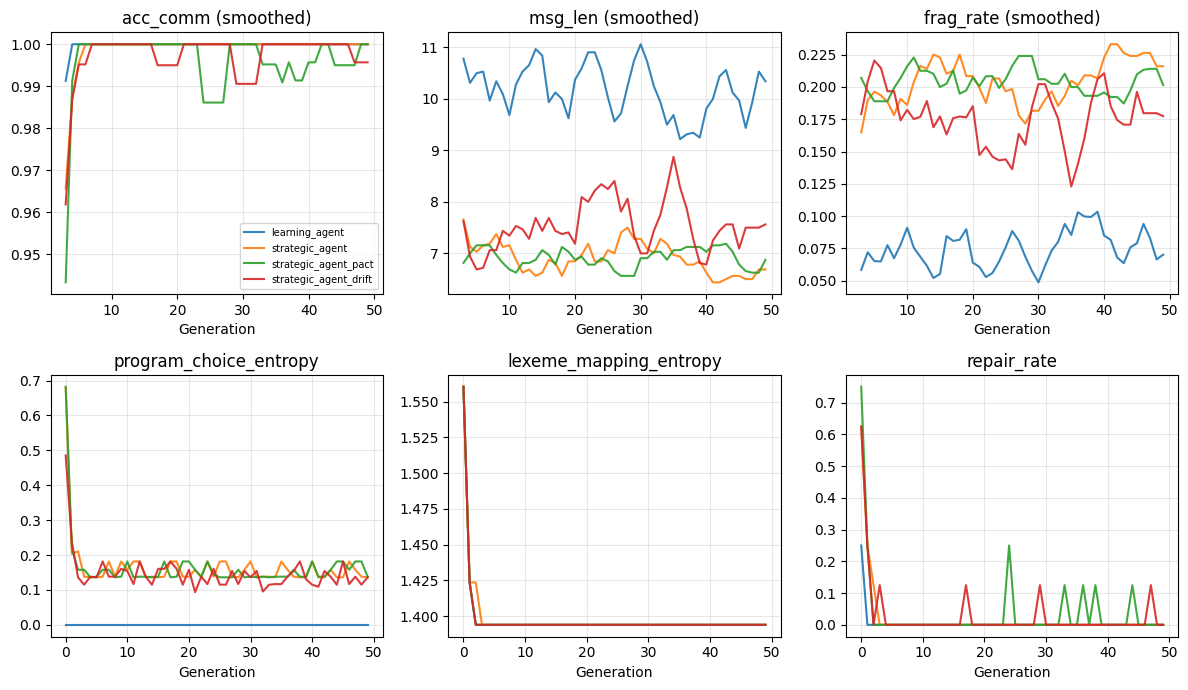

In [19]:
# Final comparison (pact-aware and drift-biased policies)
if SHOW_PLOTS:
    final_models = ["learning_agent", "strategic_agent", "strategic_agent_pact", "strategic_agent_drift"]
    fig, axes = plt.subplots(2, 3, figsize=(12, 7))
    axes = axes.reshape(2, 3)

    for j, metric in enumerate(["acc_comm", "msg_len", "frag_rate"]):
        ax = axes[0, j]
        for mode in final_models:
            sub = comm_df[(comm_df["split"] == "train") & (comm_df["model"] == mode)]
            if len(sub) > 0:
                ax.plot(sub["generation"], sub[metric].rolling(window=4).mean(), label=mode, alpha=0.9)
        ax.set_title(metric + " (smoothed)")
        ax.grid(alpha=0.3)
        ax.set_xlabel("Generation")

    for j, metric in enumerate(["program_choice_entropy", "lexeme_mapping_entropy", "repair_rate"]):
        ax = axes[1, j]
        for mode in final_models:
            sub = comm_df[(comm_df["split"] == "train") & (comm_df["model"] == mode)]
            if len(sub) > 0:
                ax.plot(sub["generation"], sub[metric], label=mode, alpha=0.9)
        ax.set_title(metric)
        ax.grid(alpha=0.3)
        ax.set_xlabel("Generation")

    axes[0, 0].legend(fontsize=7)
    plt.tight_layout()
    plt.show()


In [20]:
test_summary = comm_df[comm_df["split"] == "test"].groupby("model")[
    ["acc_comm", "msg_len", "frag_rate", "repair_rate"]
].agg(["mean", "min", "max"])

(test_summary)

acc_comm                msg_len              frag_rate  \
                           mean       min  max    mean   min    max      mean   
model                                                                           
learning_agent         1.000000  1.000000  1.0   10.95  8.25  13.50  0.053002   
strategic_agent        1.000000  1.000000  1.0    6.70  5.50   7.50  0.209091   
strategic_agent_drift  0.990909  0.954545  1.0    6.70  5.50   9.50  0.212759   
strategic_agent_pact   1.000000  1.000000  1.0    7.35  5.50   8.75  0.177403   

                                          repair_rate             
                            min       max        mean  min   max  
model                                                             
learning_agent         0.000000  0.121212        0.00  0.0  0.00  
strategic_agent        0.166667  0.272727        0.00  0.0  0.00  
strategic_agent_drift  0.078947  0.272727        0.05  0.0  0.25  
strategic_agent_pact   0.114286  0.272727        0.00  0.0  0.00

In [21]:
# Run a single drift model with strong copy effect.

def run_drift_experiment(drift_epsilon_val: float = 0.8) -> pd.DataFrame:
    data_dir = os.path.join(ROOT_DIR, "data", "model", SOURCE_SUBDIR)
    ppt_ids = list_available_ppt_ids(data_dir)
    full_dsl, _, all_utterances = build_global_dsl(ppt_ids)
    
    rng = np.random.default_rng(SEED + 100)
    prior0 = LexiconPrior(full_dsl, list(LEXEMES))
    arch_prior = prior0
    build_prior = prior0
    
    drift_pool = DriftPool()
    seen_chunks_used: Set[str] = set()
    train_rows: List[Dict[str, object]] = []
    accumulated_observations: List[pd.DataFrame] = []
    
    print(f"Running drift experiment with DRIFT_EPSILON={drift_epsilon_val}")
    
    for gen in range(NUM_GENERATIONS):
        ppt_id = int(rng.choice(np.array(ppt_ids, dtype=int)))
        ppt_df = load_trials(ppt_id).copy()
        train_df, _ = split_train_test_trials(ppt_df)
        
        gen_df, summ = simulate_generation(
            trials=train_df,
            arch_prior=arch_prior,
            build_prior=build_prior,
            model_name="strategic_agent_drift",
            all_utterances=all_utterances,
            ppt_id=ppt_id,
            pact_memory=None,
            drift_pool=drift_pool,
            alpha_prog=SPEAKER_ALPHA_PROG,
            alpha_utt=SPEAKER_ALPHA_UTT,
            beta_cost=SPEAKER_BETA_COST,
            epsilon=EPSILON,
            repair_max_turns=REPAIR_MAX_TURNS,
            pact_gamma=PACT_GAMMA,
            pact_eta=PACT_ETA,
            drift_epsilon=drift_epsilon_val,  # Use high copying rate
            drift_tau=DRIFT_TAU,
            drift_mu=DRIFT_MU,
            drift_weight_prev_gen=DRIFT_POOL_WEIGHT_PREV_GEN,
            rng=rng,
        )
        
        chunks_used_now = set(str(x) for x in str(summ.get("chunks_used", "")).split("|") if x)
        reuse_chunk_rate = len(chunks_used_now & seen_chunks_used) / max(1, len(chunks_used_now)) if chunks_used_now else 0.0
        seen_chunks_used |= chunks_used_now
        
        arch_ent = compute_lexeme_mapping_entropy(arch_prior, all_utterances, full_dsl, EPSILON)
        build_ent = compute_lexeme_mapping_entropy(build_prior, all_utterances, full_dsl, EPSILON)
        
        train_rows.append({
            "split": "train", "generation": gen, "ppt_id": ppt_id,
            "model": f"drift_eps_{drift_epsilon_val}",
            "acc_comm": as_float(summ.get("acc_comm", 0.0)),
            "msg_len": as_float(summ.get("msg_len", 0.0)),
            "frag_rate": as_float(summ.get("frag_rate", 0.0)),
            "program_choice_entropy": as_float(summ.get("program_choice_entropy", 0.0)),
            "lexeme_mapping_entropy": (arch_ent + build_ent) / 2.0,
            "reuse_chunk_rate": reuse_chunk_rate,
            "repair_rate": as_float(summ.get("repair_rate", 0.0)),
        })
        
        # Cultural transmission: bottleneck to observation pairs
        obs_df = make_transmitted_pairs(gen_df, TRANSMIT_MAX_PAIRS, TRANSMIT_SAMPLE_RATE, TRANSMIT_INCLUDE_REPAIRS, rng)
        accumulated_observations.append(obs_df)
        
        # Re-inference from prior
        fidelity = as_float(summ.get("acc_comm", 0.0))
        prior_w, ll_w = compute_adaptive_weights(fidelity)
        
        all_obs = pd.concat(accumulated_observations, ignore_index=True) if accumulated_observations else pd.DataFrame()
        
        arch_prior = LexiconPrior(full_dsl, list(LEXEMES))
        if len(all_obs) > 0:
            arch_prior = update_beliefs_modular("architect", arch_prior, all_obs, all_utterances, EPSILON, prior_w, ll_w, full_dsl)
        
        build_prior = LexiconPrior(full_dsl, list(LEXEMES))
        if len(all_obs) > 0:
            build_prior = update_beliefs_modular("builder", build_prior, all_obs, all_utterances, EPSILON, prior_w, ll_w, full_dsl)
        
        # Reconstruct drift pool
        if len(all_obs) > 0:
            h_prev, h_within = reconstruct_drift_pool_from_observations(all_obs, ppt_id)
            drift_pool.h_prev_gen = h_prev
            drift_pool.h_within_ppt = h_within
        
        if (gen + 1) % 10 == 0:
            print(f"  gen {gen+1}/{NUM_GENERATIONS}, acc={summ.get('acc_comm', 0):.3f}, msg_len={summ.get('msg_len', 0):.2f}")
    
    # Test evaluation
    test_rng = np.random.default_rng(SEED + 223)
    test_ppts = [int(x) for x in test_rng.choice(np.array(ppt_ids, dtype=int), size=TEST_NUM_PPTS, replace=False)]
    test_rows: List[Dict[str, object]] = []
    
    print("Running test evaluation...")
    for ppt in test_ppts:
        ppt_df = load_trials(ppt).copy()
        _, test_df = split_train_test_trials(ppt_df)
        
        gen_df_eval, summ_eval = simulate_generation(
            trials=test_df,
            arch_prior=arch_prior,
            build_prior=build_prior,
            model_name="strategic_agent_drift",
            all_utterances=all_utterances,
            ppt_id=ppt,
            pact_memory=None,
            drift_pool=drift_pool,
            alpha_prog=SPEAKER_ALPHA_PROG,
            alpha_utt=SPEAKER_ALPHA_UTT,
            beta_cost=SPEAKER_BETA_COST,
            epsilon=EPSILON,
            repair_max_turns=REPAIR_MAX_TURNS,
            pact_gamma=PACT_GAMMA,
            pact_eta=PACT_ETA,
            drift_epsilon=drift_epsilon_val,
            drift_tau=DRIFT_TAU,
            drift_mu=DRIFT_MU,
            drift_weight_prev_gen=DRIFT_POOL_WEIGHT_PREV_GEN,
            rng=test_rng,
        )
        
        test_rows.append({
            "split": "test", "generation": NUM_GENERATIONS, "ppt_id": ppt,
            "model": f"drift_eps_{drift_epsilon_val}",
            "acc_comm": as_float(summ_eval.get("acc_comm", 0.0)),
            "msg_len": as_float(summ_eval.get("msg_len", 0.0)),
            "frag_rate": as_float(summ_eval.get("frag_rate", 0.0)),
            "program_choice_entropy": as_float(summ_eval.get("program_choice_entropy", 0.0)),
            "lexeme_mapping_entropy": 0.0,
            "reuse_chunk_rate": 0.0,
            "repair_rate": as_float(summ_eval.get("repair_rate", 0.0)),
        })
    
    return pd.concat([pd.DataFrame(train_rows), pd.DataFrame(test_rows)], ignore_index=True)

In [22]:
drift_high_df = run_drift_experiment(drift_epsilon_val=0.8)

Running drift experiment with DRIFT_EPSILON=0.8
  gen 10/50, acc=1.000, msg_len=8.12
  gen 20/50, acc=1.000, msg_len=6.25
  gen 30/50, acc=1.000, msg_len=10.00
  gen 40/50, acc=1.000, msg_len=9.00
  gen 50/50, acc=1.000, msg_len=9.00
Running test evaluation...


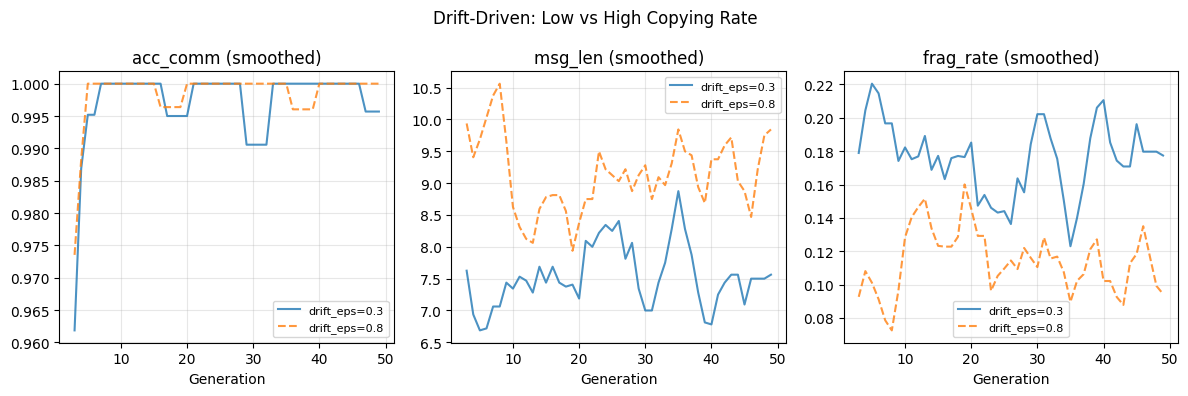

In [23]:
# Compare training curves: baseline drift (0.3) vs high drift (0.8)
if SHOW_PLOTS:
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    
    # Get baseline drift from comm_df if available
    baseline_drift = comm_df[(comm_df["split"] == "train") & (comm_df["model"] == "strategic_agent_drift")]
    high_drift = drift_high_df[drift_high_df["split"] == "train"]
    
    for j, metric in enumerate(["acc_comm", "msg_len", "frag_rate"]):
        ax = axes[j]
        if len(baseline_drift) > 0:
            ax.plot(baseline_drift["generation"], baseline_drift[metric].rolling(4).mean(), 
                    label=f"drift_eps=0.3", alpha=0.8)
        if len(high_drift) > 0:
            ax.plot(high_drift["generation"], high_drift[metric].rolling(4).mean(), 
                    label=f"drift_eps=0.8", alpha=0.8, linestyle="--")
        ax.set_title(f"{metric} (smoothed)")
        ax.set_xlabel("Generation")
        ax.grid(alpha=0.3)
        ax.legend(fontsize=8)
    
    plt.suptitle("Drift-Driven: Low vs High Copying Rate", fontsize=12)
    plt.tight_layout()
    plt.show()

In [24]:

test_baseline = comm_df[(comm_df["split"] == "test") & (comm_df["model"] == "strategic_agent_drift")]
test_high = drift_high_df[drift_high_df["split"] == "test"]

metrics = ["acc_comm", "msg_len", "frag_rate", "repair_rate"]

print(f"\n{' ':<20} {'Drift(0.3)':<15} {'Drift(0.8)':<15}")
for m in metrics:
    val_baseline = test_baseline[m].mean() if len(test_baseline) > 0 else float('nan')
    val_high = test_high[m].mean() if len(test_high) > 0 else float('nan')
    print(f"{m:<20} {val_baseline:<15.3f} {val_high:<15.3f}")


                     Drift(0.3)      Drift(0.8)     
acc_comm             0.991           1.000          
msg_len              6.700           8.100          
frag_rate            0.213           0.140          
repair_rate          0.050           0.000          
